# Première Partie : Importer les données

In [1]:
import scipy 
import numpy
import sklearn
import pandas as pds
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import scipy.cluster.hierarchy as sch
from sklearn import tree
from scipy import stats
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.cluster import DBSCAN

In [2]:
dt = pds.read_csv('569a01d3-3538-49da-a03a-63d8d3151235_Data.txt', sep="\t") # load a pandas dataframe from csv in current directory
dt = dt[:-5]
stamps = ['Time\t', 'Time Code\t', 'Country Name\t', 'Country Code\t', \
          'CO2 emissions (kg per 2011 PPP $ of GDP)\t', \
          'Access to electricity (% of population)\t', \
          'Electricity production from oil, gas and coal sources (% of total)\t', \
          'GDP per capita growth (annual %)\t', \
          'Industry (including construction), value added per worker (constant 2010 US$)\t', \
          'Agriculture, forestry, and fishing, value added per worker (constant 2010 US$)\t', \
          'International tourism, receipts (% of total exports)\t', \
          'Exports of goods and services (% of GDP)\t', 'Imports of goods and services (% of GDP)\t', \
          'Urban population (% of total population)\t', \
          'Population, total\t', 'Death rate, crude (per 1,000 people)\t', \
          'Forest area (% of land area)']
dt.columns = stamps
dt.index = dt['Country Name\t'] # on renomme la colonne des noms de pays.
dt = dt.drop(['Time\t', 'Time Code\t', 'Country Name\t', 'Country Code\t'], axis=1) # on ne garde que nos attributs.
dt = dt.dropna() # On retire les pays ayant au moins une valeur manquante 

Nous avons tout d'abord dû faire quelques modifications sur le fichier obtenu grâce au site (retraits des pays aux valeurs manquantes, modification des labels des colonnes etc).  
Une fois que nos attributs ont été choisis, nous avons vérifié qu'il n'y avait pas une corrélation importante entre certaines variables. Si c'était le cas, on retirait une des deux variables. 

### Comparaison des corrélations entre variables

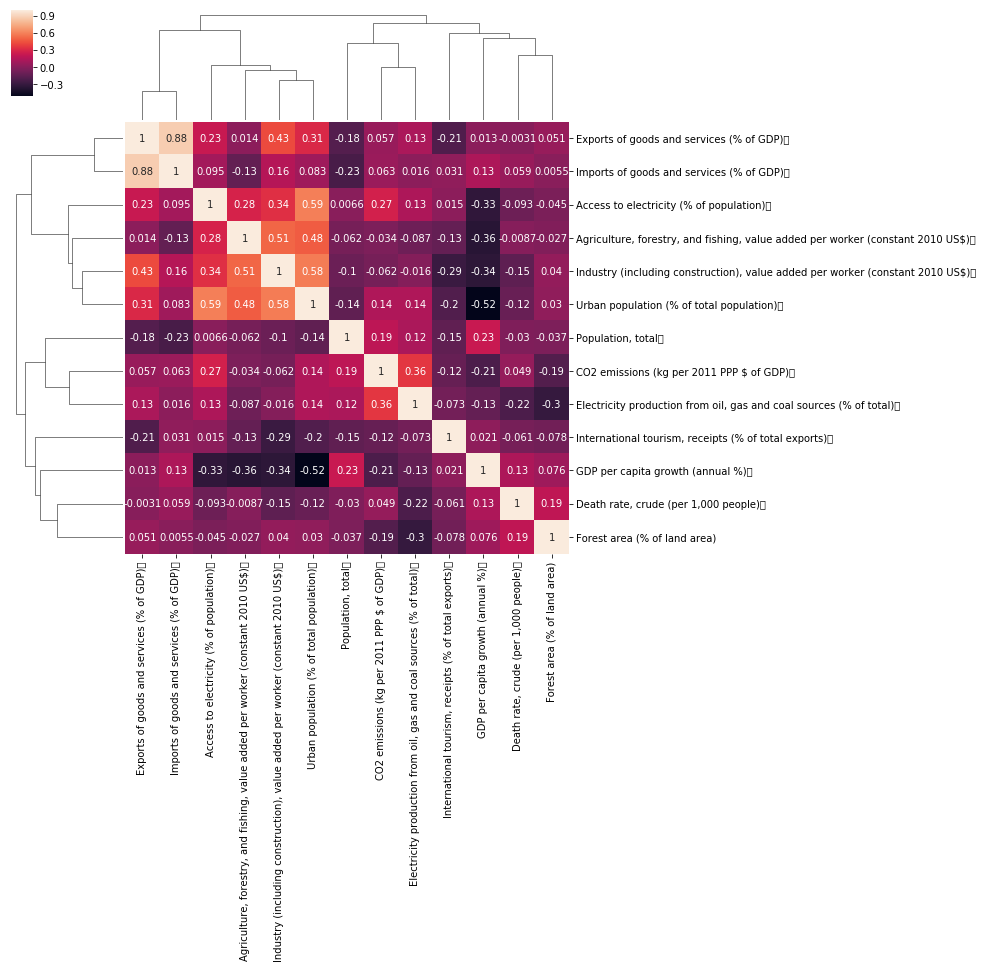

In [3]:
sns.clustermap(dt.corr(),annot=True)

In [4]:
dt = dt.drop(['Imports of goods and services (% of GDP)\t', \
              'Population, total\t', 'Urban population (% of total population)\t', \
              'Agriculture, forestry, and fishing, value added per worker (constant 2010 US$)\t',\
              'International tourism, receipts (% of total exports)\t', \
              'Industry (including construction), value added per worker (constant 2010 US$)\t', \
              'Electricity production from oil, gas and coal sources (% of total)\t'], axis=1)

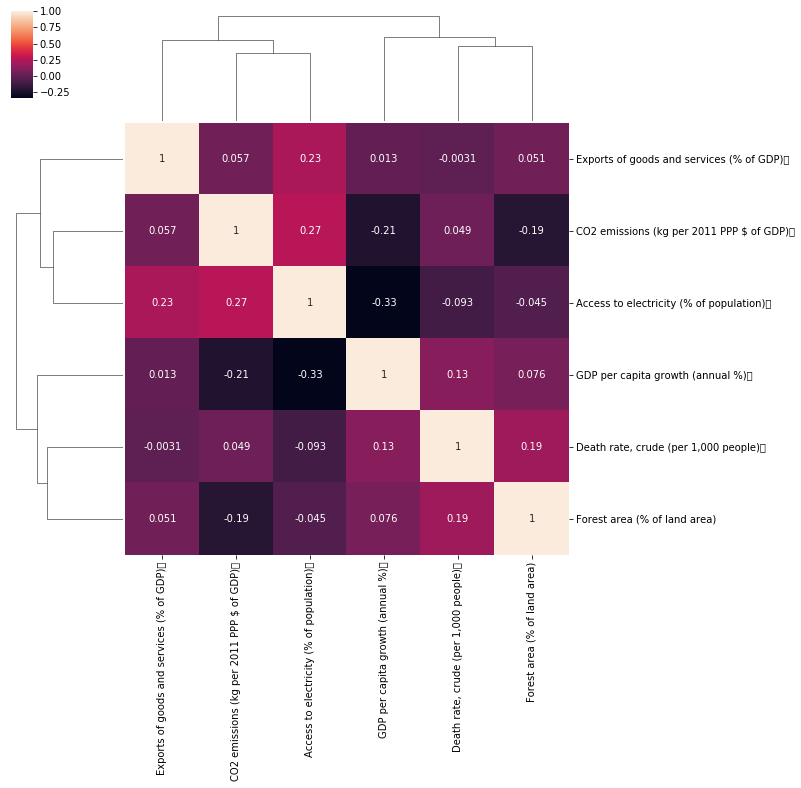

In [5]:
sns.clustermap(dt.corr(),annot=True)

Le *clustermap* permet ici de vérifier que nos variables ne sont pas trop corrélées. En effet, il n'est pas pertinent de garder des variables trop corrélées. On peut observer que les deux variables les plus corrélées sont la population urbaine et le taux de croissance du PIB. La corrélation ne s'élève qu'à 0.33, ce qui n'est pas trop élevé. 

{'whiskers': [<matplotlib.lines.Line2D at 0x25373739940>,
 'caps': [<matplotlib.lines.Line2D at 0x25373743470>,
 'boxes': [<matplotlib.lines.Line2D at 0x25373739b70>],
 'medians': [<matplotlib.lines.Line2D at 0x25373743da0>],
 'fliers': [<matplotlib.lines.Line2D at 0x25373749128>],
 'means': []}

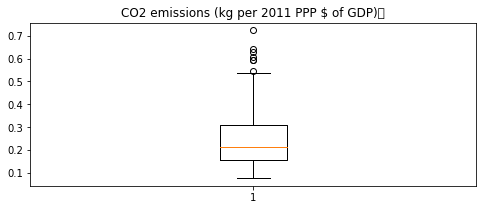

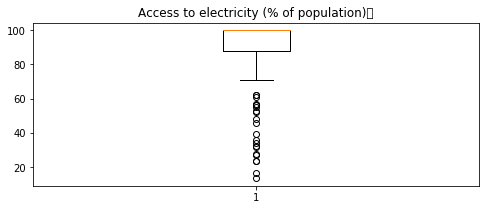

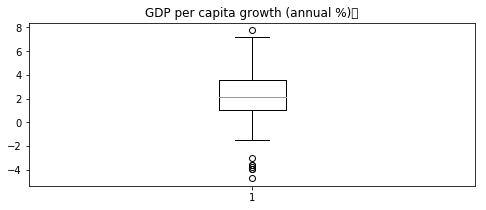

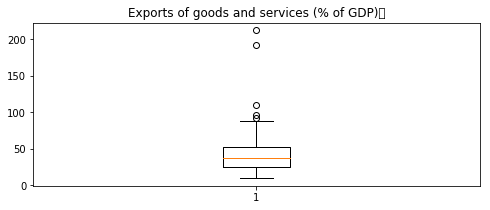

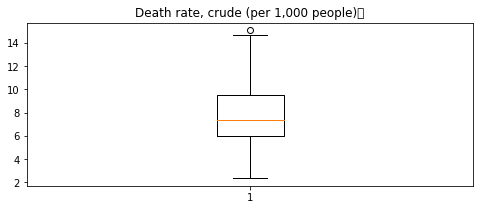

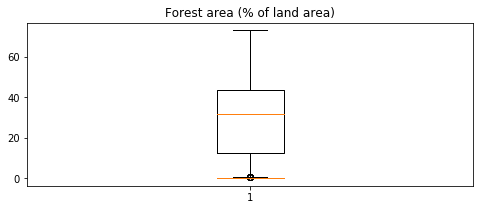

In [6]:
for i in range(6):
    fig = plt.figure(figsize=(8, 3))
    plt.title(dt.columns[i])
    plt.boxplot(dt[dt.columns[i]])
plt.boxplot(dt[dt.columns[0]])

En utilisant des boxplots sur chaque variable, on peut chercher des outliers. A priori, il ne semble pas y avoir de pays qui se démarque particulièrement sur une des variables à part le Singapour et le Luxembourg dans *Exports of goods and services*. Nous pourrons être amenés à retirer ces 2 pays plus tard s'ils se démarquent trop (exemple : s'ils forment un cluster à eux tous seuls). 

# Deuxième partie : Clustering

## Méthode des K-Means

Le premier algorithme de clustering que nous allons utiliser est l'algorithme appelé *K-means*.  
Tout d'abord, on choisit le nombre de clusters (k) que l'on souhaite. On choisit k points qui seront les positions moyennes des clusters. Ensuite, l'algorithme place chaque point dans le cluster le plus proche de lui. Une fois que tous les points sont classés, on recalcule la position moyenne de chaque cluster (en fonction des points présents dans ce cluster). On replace à nouveau chaque point dans le cluster le plus proche et ainsi de suite, jusqu'à atteindre convergence des clusters. 

### SSE et Silhouette

Nous allons utiliser plusieurs outils pour déterminer le bon candidat pour le choix du nombre de clusters. On va tout d'abord utiliser la méthode SSE. Cette méthode se base sur une minimisation de la somme des carrés des écarts. 

In [7]:
sse_list = []
silhouette_list = []
k_list = range(2,11)
for i in k_list:
    km_i_clusters=KMeans(n_clusters=i)
    km_i_clusters = km_i_clusters.fit(dt)
    clusters = km_i_clusters.predict(dt)
    sse_list = sse_list + [km_i_clusters.inertia_]
    silhouette_list = silhouette_list + [metrics.silhouette_score(dt, clusters)]
print(sse_list)

[158227.44004323374, 105474.84153336225, 76718.8361603927, 57647.18008663467, 48275.27126376719, 40253.240129609774, 36409.95654664785, 31738.375433724454, 28070.801694328344]


Text(0,0.5,'SSE')

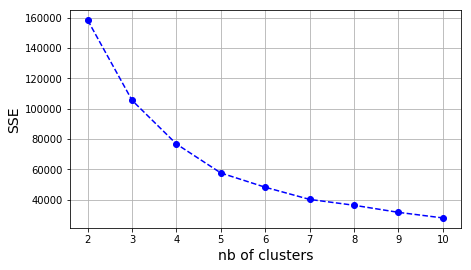

In [8]:
fig = plt.figure(figsize=(7, 4))
plt.plot(k_list,sse_list,'bo--')
plt.grid()
plt.xlabel("nb of clusters",fontsize=14)
plt.ylabel("SSE",fontsize=14)

3 groupes suffisent pour avoir une bonne SSE.

Text(0,0.5,'Silhouette')

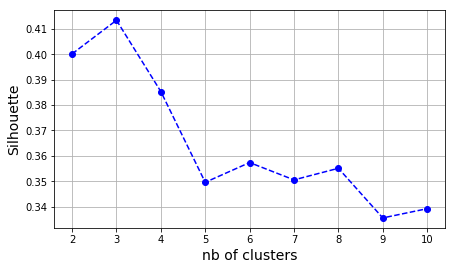

In [9]:
fig = plt.figure(figsize=(7, 4))
plt.plot(k_list,silhouette_list,'bo--')
plt.grid()
plt.xlabel("nb of clusters",fontsize=14)
plt.ylabel("Silhouette",fontsize=14)

Le coefficient silhouette calcule pour chaque point la distance moyenne avec tous les points du même cluster que ce point et la distance moyenne avec tous les points qui ne sont pas dans le même cluster que ce point. Eest une valeur comprise entre -1 et 1. Lorsque les points sont bien classés, la valeur du coefficient silhouette tend vers 1, tandis qu'elle tend vers -1 quand les points sont mal classés. 

Dans notre cas, la valeur du coefficient silhouette est assez élevée, ce qui témoigne à priori d'un bon clustering. Choisir k = 3 semble être un bon choix. 

### Méthode

In [10]:
km = KMeans(n_clusters = 3) # create a KMeans object
km.fit(dt) # compute the clusters

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

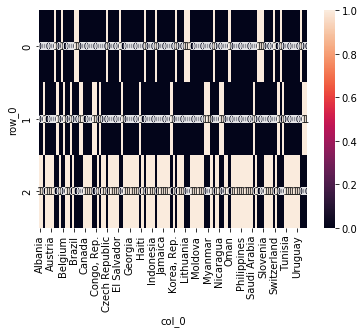

In [11]:
km.cluster_centers_
clusters = km.labels_ # get cluster labels for all objects
crosstab = pds.crosstab(clusters, dt.index)
sns.heatmap(crosstab, annot=True)

Cette visualisation est peu efficace, on ne voit pas bien dans quel cluster se trouvent les différents pays. Cette visualisation est pertinente lorsque les individus (ici les pays) ont une variable qualitative permettant déjà de classer ces individus. Ici, cela pourrait être le continent, la position géographique etc. 

Text(0.5,1,"Visualisation des pays selon leur cluster d'appartenance")

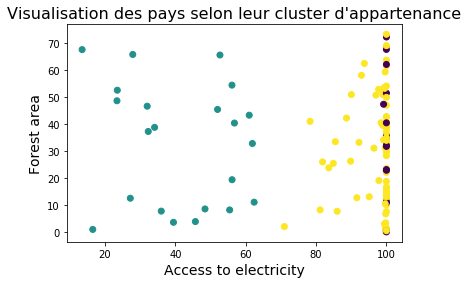

In [12]:
plt.scatter(dt.iloc[:,1], dt.iloc[:,5], c = clusters)
plt.xlabel("Access to electricity",fontsize=14)
plt.ylabel("Forest area",fontsize=14)
plt.title("Visualisation des pays selon leur cluster d'appartenance", fontsize = 16)

En représentant 2 de nos variables en 2D, on peut déterminer les variables qui ont été les plus déterminantes dans le choix des clusters. Après plusieurs visualisations, nous avons remarqué que la variable *Access to electricity* a un lien avec le cluster de couleur bleu. En effet, comme on peut le voir sur la figure ci-dessus, tous les pays de couleur bleu ont un accès à l'électricité réduit. En revanche, il n'est pas possible de différencier les clusters violet et jaune sur cette figure. 

Text(0.5,1,"Visualisation des pays selon leur cluster d'appartenance")

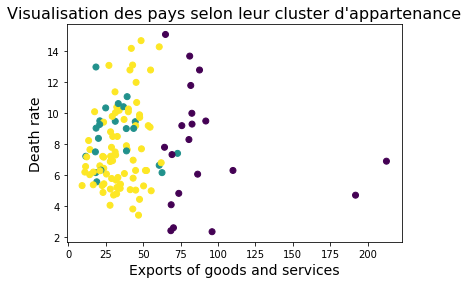

In [13]:
plt.scatter(dt.iloc[:,3], dt.iloc[:,4], c = clusters)
plt.xlabel("Exports of goods and services",fontsize=14)
plt.ylabel("Death rate",fontsize=14)
plt.title("Visualisation des pays selon leur cluster d'appartenance", fontsize = 16)

Ce deuxième graphique nous permet de différencier le cluster violet du cluster jaune. On voit que l'axe x, donc les exports de produits et services, sépare le cluster jaune des 2 autres. Les pays du cluster jaune ont plus d'exports que les autres. 

La méthode K-means a donc séparé les pays en fonction de leur export de produits et services et de leur accès à l'électricité. 

In [14]:
# sns.pairplot(data=dt, hue="clusters")

c1  = []
c2  = []
c3  = []
#c4  = []
dt.index[1]
lab = km.labels_
for i in range(len(lab)) :
    if lab[i] == 0 :
        c1.append(dt.index[i])
    elif lab[i] == 1 :
        c2.append(dt.index[i])
    else :
        c3.append(dt.index[i])
print(c1)
print(c2)
print(c3)
#print(c4)

['Bahrain', 'Belgium', 'Brunei Darussalam', 'Bulgaria', 'Czech Republic', 'Estonia', 'Hungary', 'Ireland', 'Kuwait', 'Lithuania', 'Luxembourg', 'Malaysia', 'Netherlands', 'Oman', 'Singapore', 'Slovak Republic', 'Slovenia', 'Switzerland', 'Thailand', 'Vietnam']
['Angola', 'Bangladesh', 'Benin', 'Botswana', 'Cambodia', 'Cameroon', 'Congo, Dem. Rep.', 'Congo, Rep.', "Cote d'Ivoire", 'Ethiopia', 'Haiti', 'Kenya', 'Mozambique', 'Myanmar', 'Namibia', 'Niger', 'Nigeria', 'Senegal', 'Tanzania', 'Togo', 'Zambia', 'Zimbabwe']
['Albania', 'Algeria', 'Argentina', 'Australia', 'Austria', 'Azerbaijan', 'Belarus', 'Bolivia', 'Bosnia and Herzegovina', 'Brazil', 'Canada', 'Chile', 'China', 'Colombia', 'Costa Rica', 'Croatia', 'Cyprus', 'Denmark', 'Dominican Republic', 'Ecuador', 'Egypt, Arab Rep.', 'El Salvador', 'Finland', 'France', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala', 'Honduras', 'Iceland', 'India', 'Indonesia', 'Iraq', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', '

In [15]:
dt.index[1]
km.labels_[1]

2

In [16]:
print(len(c1), len(c2), len(c3)) # Nombre de pays par clusters. 

20 22 78


L'utilisation de cette méthode ne s'avère pas très pertinente car les variables ont des ordres de grandeur peu comparables. Ainsi, on se retrouve à avoir certaines variables qui ont beaucoup plus d'importance que d'autres. Cela est ici clairement remarquable car seuls 2 variables ont un rôle sur les critères d'attribution des clusters.  
Pour faire face à ce problème, on peut normaliser les données. 

## K-means en normalisant

In [17]:
dt_normalized = (dt-dt.mean())/dt.std()

On peut effectuer à nouveau les mêmes calculs :

In [18]:
sse_list = []
silhouette_list = []
k_list = range(2,11)
for i in k_list:
    km_i_clusters=KMeans(n_clusters=i)
    km_i_clusters = km_i_clusters.fit(dt_normalized)
    clusters = km_i_clusters.predict(dt_normalized)
    sse_list = sse_list + [km_i_clusters.inertia_]
    silhouette_list = silhouette_list + [metrics.silhouette_score(dt_normalized, clusters)]
print(sse_list)

[580.3648995336973, 492.4602833699397, 423.76904868439493, 370.2361862143374, 325.0603974142383, 293.6670039513429, 266.74601872383573, 252.60779503578829, 230.36283777350639]


Text(0,0.5,'SSE')

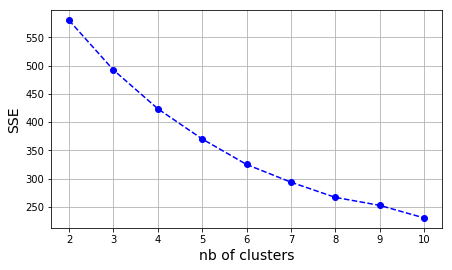

In [19]:
fig = plt.figure(figsize=(7, 4))
plt.plot(k_list,sse_list,'bo--')
plt.grid()
plt.xlabel("nb of clusters",fontsize=14)
plt.ylabel("SSE",fontsize=14)

Text(0,0.5,'Silhouette')

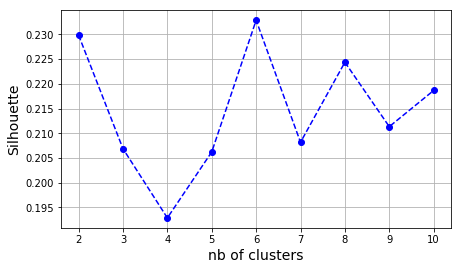

In [20]:
fig = plt.figure(figsize=(7, 4))
plt.plot(k_list,silhouette_list,'bo--')
plt.grid()
plt.xlabel("nb of clusters",fontsize=14)
plt.ylabel("Silhouette",fontsize=14)

Pour éviter de prendre un trop grand nombre de clusters, on privilégie ici 3 clusters à nouveau. Le coefficient silhouette n'est pas trop faible et la SSE sera moins élevée que pour 2 groupes.

In [21]:
km = KMeans(n_clusters = 3) # create a KMeans object
km.fit(dt_normalized) # compute the clusters
km.cluster_centers_
clusters_km = km.labels_ # get cluster labels for all objects

In [22]:
print(sum(clusters==0), sum(clusters==1), sum(clusters==2))

14 21 12


Les 3 groupes formés sont plutôt homogènes, aucun n'est composé que de 2 ou 3 pays. Les outliers potentiels identifiés précédemment (Singapour, Luxembourg) ne semblent pas déranger. 

Text(0.5,1,"Visualisation des pays selon leur cluster d'appartenance")

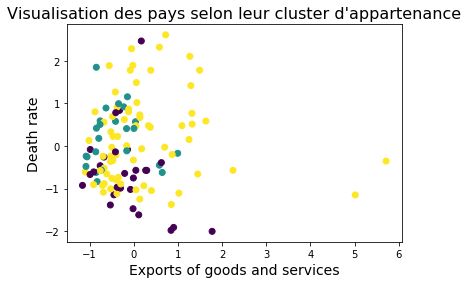

In [23]:
plt.scatter(dt_normalized.iloc[:,3], dt_normalized.iloc[:,4], c = clusters_km)
plt.xlabel("Exports of goods and services",fontsize=14)
plt.ylabel("Death rate",fontsize=14)
plt.title("Visualisation des pays selon leur cluster d'appartenance", fontsize = 16)

Text(0.5,1,"Visualisation des pays selon leur cluster d'appartenance")

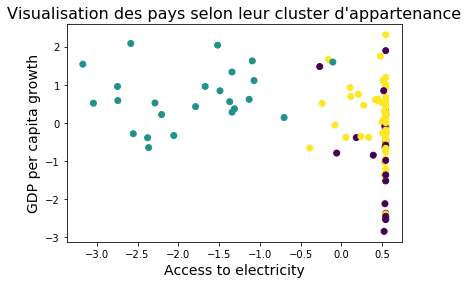

In [24]:
plt.scatter(dt_normalized.iloc[:,1], dt_normalized.iloc[:,2], c = clusters_km)
plt.xlabel("Access to electricity",fontsize=14)
plt.ylabel("GDP per capita growth",fontsize=14)
plt.title("Visualisation des pays selon leur cluster d'appartenance", fontsize = 16)

A présent, les clusters ne sont plus expliqués que par 2 variables comme avant, la distinction est beaucoup moins évidente. En revanche, la variable *Access to electricity* reste un critère primordial : cette variable différencie le cluster bleu. On en déduit que cette variable contient bien d'importantes différences entre les pays. 

## Hierarchical clustering

Le clustering hierarchique peut être agglomeratif ou divisif, deux types qui ne se diffèrent que par le sens de regroupement. Le clustering hierarchique agglomeratif que l'on va utiliser part de tous les points et les regroupe en $n$ clusters cependant le nombre $n$ diminue jusqu'à $1$. On peut alors choisir le nombre de clusters a posteriori. Le regroupement se fait grâce à une fonction de distance donnée lors de l'appel.

Tout d'abord, on appelle une fonction qui calcule l'arbre d'aggrégation et on dessine le dendrogramme associé.

In [25]:
agg = sch.linkage(dt_normalized, method='complete', metric='euclidean')

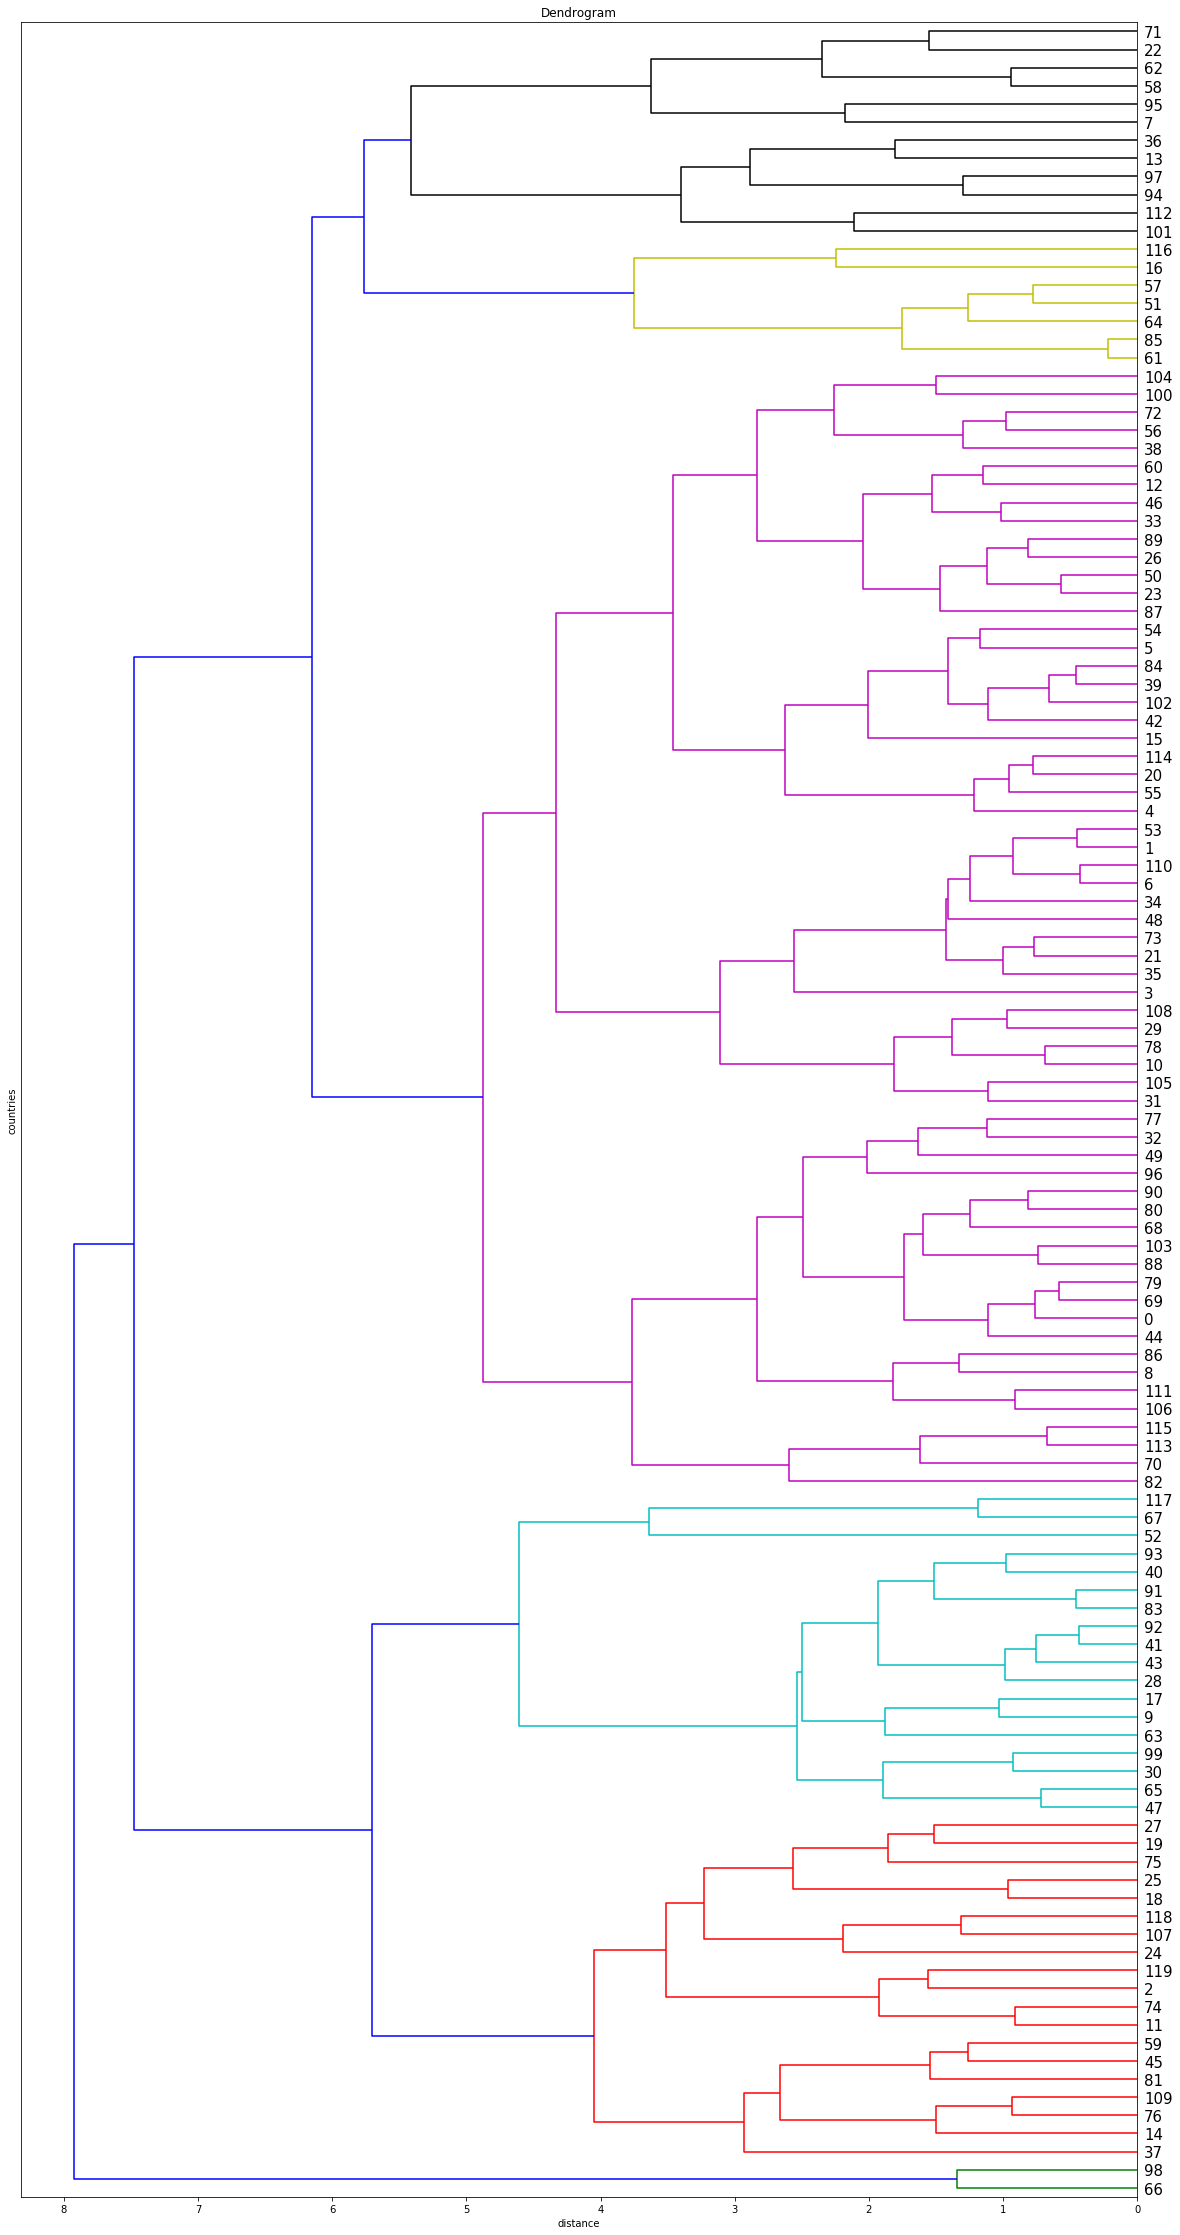

In [26]:
fig = plt.figure(figsize=(20, 40))
dendro = sch.dendrogram(agg, orientation='left', leaf_rotation=0, leaf_font_size=15)
# in blue: nodes with a merging distance >= 0.7 * maximal merging distance

plt.title('Dendrogram')
plt.ylabel('countries')
plt.xlabel('distance');

Ce dendrogramme est plutôt pas clair, on ne va se alors limiter qu'à la zone qui nous intéresse, c'est-à-dire les $6$ derniers clusters et moins.

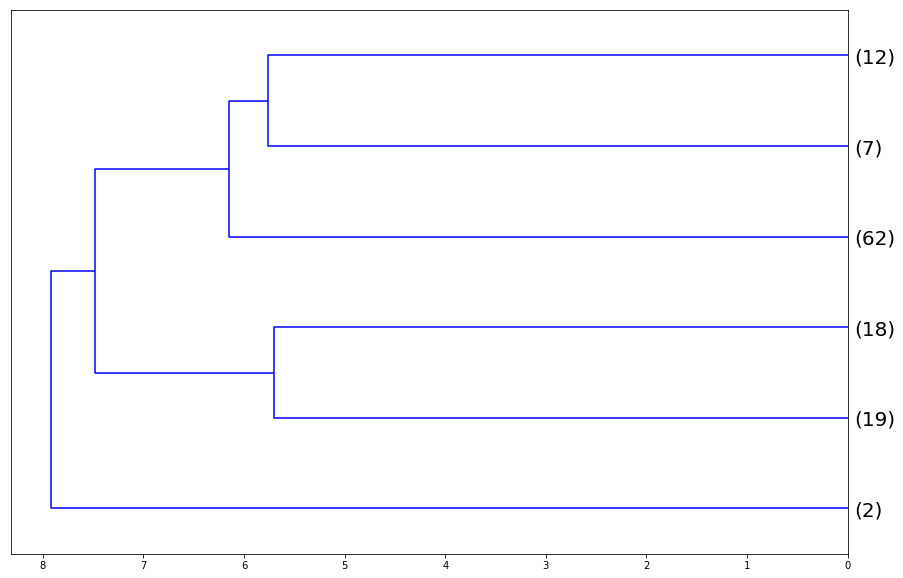

In [27]:
fig = plt.figure(figsize=(15, 10))
dendro = sch.dendrogram(agg, orientation='left', p=6, truncate_mode='lastp',
                        show_leaf_counts=True, leaf_rotation=0, leaf_font_size=20)

Text(0,0.5,'Distance entre clusters fusionnés')

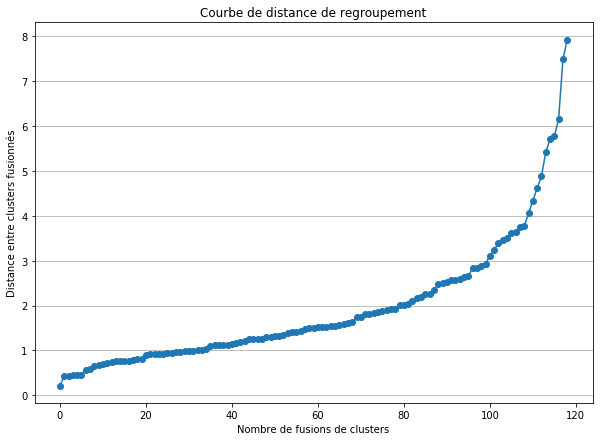

In [28]:
fig = plt.figure(figsize=(10, 7))
plt.plot(agg[:,2],'o-')
plt.grid(axis='y')
plt.title("Courbe de distance de regroupement")
plt.xlabel("Nombre de fusions de clusters")
plt.ylabel("Distance entre clusters fusionnés")

La courbe de la distance de regroupement nous montre la similaritude entre les clusters fusionnés à chaque étape. 

On remarque que l'un des 2 clusters principaux est composé seulement des deux pays. On est donc assez suspects. En regardant quels sont ces deux pays, on remarque que ce sont le Luxembourg et Singapour : les 2 pays remarqués au début de notre analyse. On va ici les retirer de notre jeu de données.

In [29]:
nb_clust = 2
clusters = sch.fcluster(agg, nb_clust, criterion='maxclust')
c2  = []
lab = km.labels_
for i in range(len(clusters)) :
    if clusters[i] == 1 :
        c2.append(dt_normalized.index[i])
print(c2)

dt_normalized_ini = dt_normalized
dt_normalized = dt_normalized.drop(['Luxembourg', 'Singapore'], axis=0)

['Luxembourg', 'Singapore']


On va étudier l'influence de la fonction de distance. On utilise les méthodes *complete, average et ward* pour les mesures *euclidienne, manhattan*. La distance de Ward n'est pas appliquable dans le cas de mesure *manhattan*.

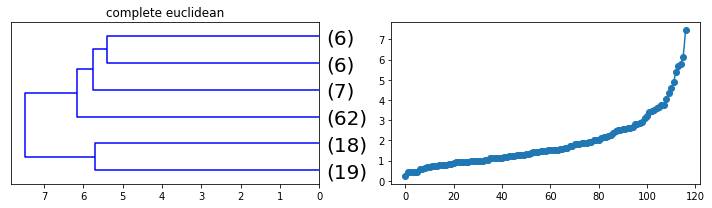

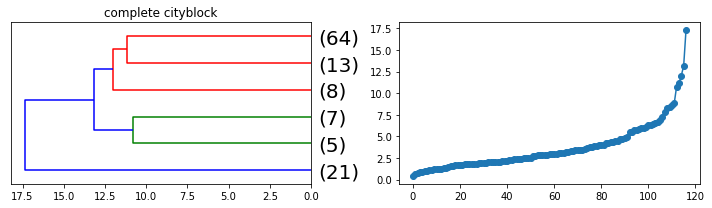

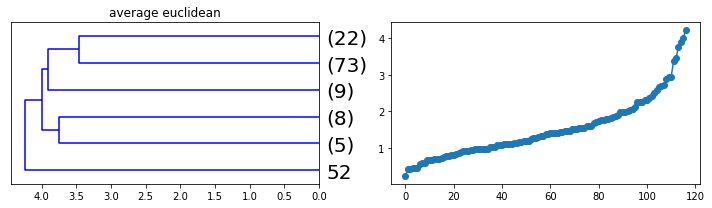

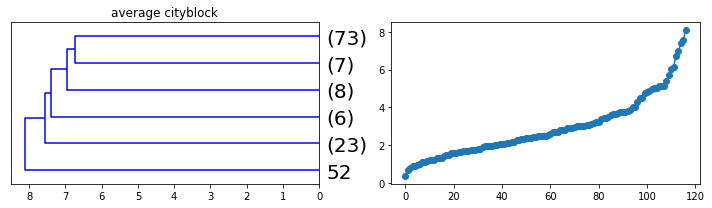

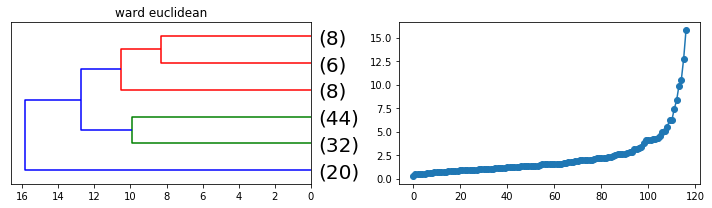

In [30]:
methods = ["complete", "average", "ward"]
metric = ["euclidean","cityblock"]

dendros = {}
plots = {}
p = True
for d in methods:
    for c in metric:
        if d!= 'ward':
            agg = sch.linkage(dt_normalized, method=d, metric=c)
        elif p:
            agg = sch.linkage(dt_normalized, method=d, metric='euclidean')
            p = False
        else:
            break
        fig = plt.figure(figsize=(10, 3))
        plt.subplot(1, 2, 1)
        plt.title(d + ' ' + c)
        dendros[d+"-"+c] = sch.dendrogram(agg, orientation='left', p=6, truncate_mode='lastp',
                        show_leaf_counts=True, leaf_rotation=0, leaf_font_size=20)
        plt.subplot(1, 2, 2)
        plots[d+"-"+c] = plt.plot(agg[:,2],'o-')
        plt.tight_layout()

Les courbes de distance de regroupement associées aux dendogrammes permettent de définir un nombre de clusters idéal. Comme nous n'allons pas tous les faire, nous devons faire un choix parmis ceux-ci. La méthode *complete euclidean* présente un fort pic de croissance sur la courbe de distance, ce qui montre qu'à partir d'une certaine fusion (autour de 110), les fusions suivantes s'effectuent entre des clusters très différents (distance élevée). Le but est d'avoir des clusters les plus différents possibles, donc on peut garder les clusters avant ce pic. 

La méthode *complete euclidean* est donc bien. Pour déterminer le nombre de clusters idéal, on prend la distance au nombre de fusion limite, avant le pic. On obtient un nombre de clusters égal à 3.

De plus, la méthode *ward euclidean* nous semble intéressante car dans durant les 80 premières fusions de clusters, la distance est faible (les clusters fusionnés sont donc similaires). Soudainement (autour de la 100ème fusion), on observe un pic de croissance. A nouveau, on relève le nombre de cluster idéal. On obtient à nouveau 3.

### Methode ward, metric euclidean

In [31]:
nb_clust = 3
agg = sch.linkage(dt_normalized, method='ward', metric='euclidean')
clusters = sch.fcluster(agg, nb_clust, criterion='maxclust')
print(clusters)
c1  = []
c2  = []
c3  = []
lab = km.labels_
for i in range(len(clusters)) :
    if clusters[i] == 1 :
        c1.append(dt_normalized.index[i])
    elif clusters[i] == 2 :
        c2.append(dt_normalized.index[i])
    else:
        c3.append(dt_normalized.index[i])
print(c1)
print(c2)
print(c3)

[2 2 1 3 2 2 2 3 2 3 2 1 2 3 1 2 3 3 1 1 2 2 3 2 1 1 2 1 2 2 2 2 2 2 2 2 3
 1 2 2 2 2 2 2 2 1 2 2 2 2 2 3 2 2 2 2 2 3 3 1 2 3 3 2 3 2 2 2 2 2 3 2 2 1
 1 1 2 2 2 2 1 1 2 2 3 2 2 2 2 2 2 2 2 3 3 2 3 2 2 3 2 2 2 2 2 1 2 1 2 2 3
 2 2 2 3 2 1 1]
['Angola', 'Benin', 'Botswana', 'Cambodia', 'Cameroon', 'Congo, Dem. Rep.', 'Congo, Rep.', "Cote d'Ivoire", 'Ethiopia', 'Haiti', 'Kenya', 'Mozambique', 'Myanmar', 'Namibia', 'Niger', 'Nigeria', 'Tanzania', 'Togo', 'Zambia', 'Zimbabwe']
['Albania', 'Algeria', 'Australia', 'Austria', 'Azerbaijan', 'Bangladesh', 'Belgium', 'Bolivia', 'Brazil', 'Canada', 'Chile', 'Colombia', 'Costa Rica', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Dominican Republic', 'Ecuador', 'Egypt, Arab Rep.', 'El Salvador', 'Finland', 'France', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala', 'Honduras', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Korea, Rep.', 'Latvia', 'Lithuania', 'Malaysia', 'Mauritius', 'Mexico',

In [32]:
print(len(c1), len(c2), len(c3))

20 76 22


### Methode complete, metric euclidean

In [33]:
nb_clust = 3
agg = sch.linkage(dt_normalized, method='complete', metric='euclidean')
clusters2 = sch.fcluster(agg, nb_clust, criterion='maxclust')
print(clusters2)
c1  = []
c2  = []
c3  = []
lab = km.labels_
for i in range(len(clusters2)) :
    if clusters2[i] == 1 :
        c1.append(dt_normalized.index[i])
    elif clusters2[i] == 2 :
        c2.append(dt_normalized.index[i])    
    else:
        c3.append(dt_normalized.index[i])
print(c1)
print(c2)
print(c3)


[2 2 1 2 2 2 2 3 2 1 2 1 2 3 1 2 3 1 1 1 2 2 3 2 1 1 2 1 1 2 1 2 2 2 2 2 3
 1 2 2 1 1 2 1 2 1 2 1 2 2 2 3 1 2 2 2 2 3 3 1 2 3 3 1 3 1 1 2 2 2 3 2 2 1
 1 1 2 2 2 2 1 2 1 2 3 2 2 2 2 2 1 1 1 3 3 2 3 1 2 3 2 2 2 2 2 1 2 1 2 2 3
 2 2 2 3 1 1 1]
['Angola', 'Belarus', 'Benin', 'Botswana', 'Bulgaria', 'Cambodia', 'Cameroon', 'Congo, Dem. Rep.', 'Congo, Rep.', "Cote d'Ivoire", 'Croatia', 'Czech Republic', 'Ethiopia', 'Georgia', 'Germany', 'Greece', 'Haiti', 'Hungary', 'Ireland', 'Kenya', 'Latvia', 'Lithuania', 'Malaysia', 'Mozambique', 'Myanmar', 'Namibia', 'Niger', 'North Macedonia', 'Poland', 'Portugal', 'Romania', 'Slovak Republic', 'Tanzania', 'Togo', 'Vietnam', 'Zambia', 'Zimbabwe']
['Albania', 'Algeria', 'Argentina', 'Australia', 'Austria', 'Azerbaijan', 'Bangladesh', 'Belgium', 'Bolivia', 'Brazil', 'Canada', 'Chile', 'Colombia', 'Costa Rica', 'Cyprus', 'Denmark', 'Dominican Republic', 'Ecuador', 'Egypt, Arab Rep.', 'El Salvador', 'Finland', 'France', 'Ghana', 'Guatemala', 'Honduras', 'I

In [34]:
print(len(c1), len(c2), len(c3))

37 62 19


Nous avons donc utilisé 2 méthodes hiérarchiques différentes, que nous pourrons ensuite comparer avec les outils adéquats. 2 outliers ont été retirés et nous obtenons des clusters comptant au minimiun environ 20 pays. Nous sommes donc satisfaits. 

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


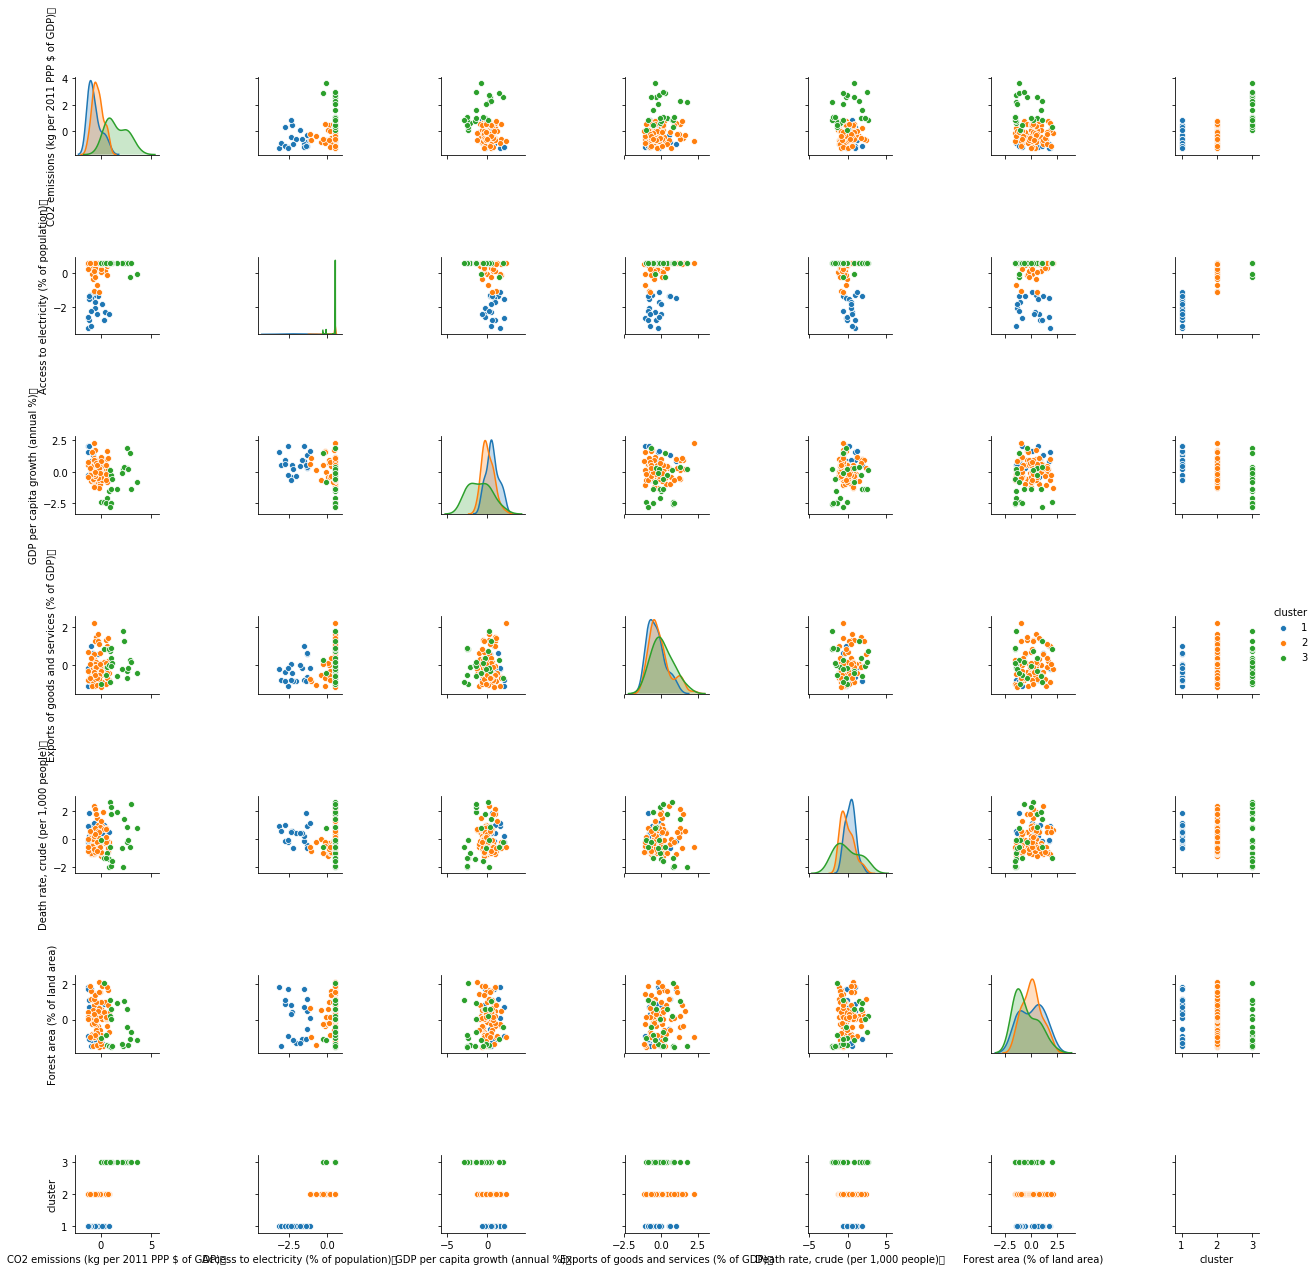

In [35]:
df_all = dt_normalized.copy()
df_all['cluster']= clusters
sns.pairplot(data=df_all,hue='cluster')

Le graphique pairplot nous permet de répresenter les clusters en fonction de 2 variables à la fois. On voit que pour certaines variables, les clusters sont bien espacés et on peut les bien différencier. C'est le cas pour les émission du dioxyde de carbon où un cluster est en haut par rapport aux autres et sa moyenne diffère significativement des 2 autres.

La même chose apparaît pour la variable l'accès à l'éléctricité, ou le même cluster a que des valeurs très proches de 100%, on peut donc conclure qu'il s'agit des pays bien développés avec un accès aisé à l'éléctricité et beaucoup d'émissions de CO2. On voit aussi un autre cluster où les valeurs sont bien petites, ce sont les pays en développement qui manquent en accès à l'éléctricité.

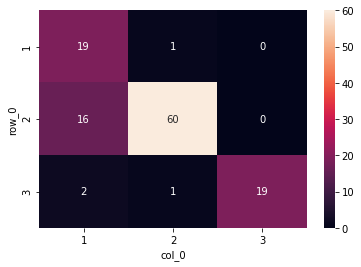

In [36]:
crosstab = pds.crosstab(clusters,clusters2)
sns.heatmap(crosstab, annot=True)

Pour comparer la composition des clusters des 2 méthodes hiérarchiques, nous allons utiliser une table de contingence entre les 2 listes de clusters obtenues (0,1 ou 2 suivant le cluster d'appartenance). 
Dans cette table, on voit que 19 pays sont présents dans le même cluster pour les 2 méthodes, 60 pays sont présents dans un autre même cluster, puis 19 autres pays sont dans le dernier cluster des 2 méthodes.  
Pour quantifier cette ressemblance, on calcule l'entropie de chaque cluster, pour chaque méthode.  

In [37]:
proba = crosstab.values/crosstab.values.sum(axis=1, keepdims=True) # divide each element of a row by the sum of the row
entropy = [stats.entropy(row, base=2) for row in proba]
print("entropy of each cluster: ", entropy)

entropy of each cluster:  [0.2863969571159562, 0.7424875695421236, 0.699857857026928]


In [38]:
proba = crosstab.values/crosstab.values.sum(axis=0, keepdims=True) # divide each element of a row by the sum of the row
entropy = [stats.entropy(row, base=2) for row in proba]
print("entropy of each cluster: ", entropy)

entropy of each cluster:  [0.19665694499474506, 0.8918320387094191, 0.4002109858633401]


Le premier calcul (somme selon l'axe 1) nous donne l'entropie des clusters selon la méthode ward. L'entropie varie entre 0 et 1. Plus l'entropie est proche de 0, moins il y a de désordre dans le cluster.  

Pour le premier cluster, on observe une entropie de 0.29. Cette valeur est faible, ce qui veut dire que ce cluster est plutôt bien déterminé. Concrètement, les pays présents dans ce cluster sont en majorité groupés dans le même cluster avec l'autre méthode hiérarchique (complete).  

Pour les 2 autres clusters, l'entropie est plus élevée (0.74 et 0.70). Il y a donc plus de désordre dans ces clusters. Les pays se retrouvent donc séparés dans plusieurs clusters avec la méthode complete.  
Il est intéressant de remarquer que les pays groupés dans le plus gros groupe pour la méthode ward (76 pays dans le cluster 2) se sont retrouvés uniquement dans 2 clusters pour l'autre méthode (60 et 16). Il n'y a donc eu aucun pays dans le dernier cluster. On peut donc en déduire que tous les pays ont été séparés pour la même raison.

Le deuxième calcul d'entropie (somme selon l'axe 0) permet de mesurer le désordre des clusters de la méthode euclidean. Les entropies obtenues pour les 3 clusters sont 0.2, 0.89, 0.40. Dans le premier cluster, les pays sont proches et donc peu susceptibles d'aller dans un autre cluster, tandis que pour le cluster 2, beaucoup de pays se retrouvent séparés dans plusieurs clusters. 

In [39]:
dt_compare = dt_normalized_ini
dt_compare.drop(['Luxembourg', 'Singapore'], axis=0)
km = KMeans(n_clusters = 3) # create a KMeans object
km.fit(dt_normalized) # compute the clusters
km.cluster_centers_
clusters_km = km.labels_ # get cluster labels for all objects
clusters_km

array([1, 0, 2, 0, 0, 1, 0, 0, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2, 1, 0,
       0, 1, 2, 2, 1, 2, 1, 0, 1, 1, 1, 1, 0, 0, 1, 2, 1, 1, 1, 1, 1, 1,
       1, 2, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 2, 1, 0, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 2, 2, 2, 2, 1, 1, 1, 2, 2, 1, 1, 0, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 0, 1, 1, 1, 1, 0, 2, 1, 2, 0, 0,
       0, 1, 1, 1, 0, 1, 2, 2])

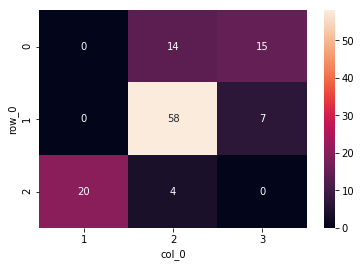

In [40]:
crosstab = pds.crosstab(clusters_km,clusters)
sns.heatmap(crosstab, annot=True)

Il nous a également été possible de comparer la méthode des *K*-means avec les méthodes hiérarchiques avec les tables de contingence.  
En comparant les clusters de K-means à ceux issus de la méthode ward, on observe qu'on retrouve de fortes similitudes, tandis que la ressemblance entre les clusters de K-means et ceux de la méthode euclidean est moins frappante.

Ici, parce que les clusters de K-means et de l'hiérarchie n'ont pas les mêmes indexes, on doit s'orienter par rapport à la deuxième diagonale (de bas en haut)

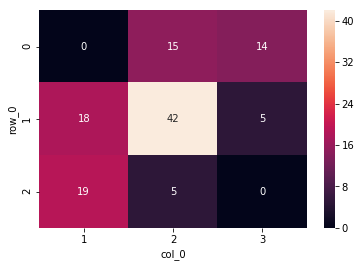

In [41]:
crosstab = pds.crosstab(clusters_km,clusters2)
sns.heatmap(crosstab, annot=True)

## Méthode DBSCAN

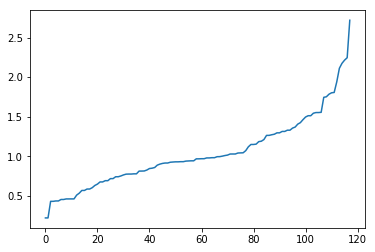

In [42]:
from sklearn.neighbors import NearestNeighbors 
dt_normalized_ini = dt_normalized
neigh = NearestNeighbors(n_neighbors=4)
nbrs = neigh.fit(dt_normalized_ini)
distances, indices = nbrs.kneighbors(dt_normalized_ini)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

Pour utiliser pour DBSCAN, on doit d'abord déterminer epsilon. Pour cela, on utilise la courbe de distance au 4ème plus proche voisin, présente ci-dessous. Avec celle-ci, on définit epsilon comme la valeur de la distance du voisin au creux de la courbure. 

In [43]:
dbscan = DBSCAN(eps = 1.5, min_samples = 3)
dbscan.fit(dt_normalized_ini)
clusters = dbscan.labels_
print(clusters)

[ 0  0  1  0  0  0  0 -1  0  0  0  1  0 -1  0  0 -1  0 -1 -1  0  0 -1  0
 -1 -1  0 -1  0  0  0  0  0  0  0  0 -1 -1  0  0  0  0  0  0  0  0  0  0
  0 -1  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0
  0  1 -1  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0 -1  0  0  0  0  0  1  0  0  0  0 -1  0  0  0 -1  0  1  1]


On choisit un epsilon autour de *1.5*. Malheuresement, dans cette configuration la méthode DBSCAN ne fonctionne pas et elle trouve beaucoup de valeurs abberantes et très peu de valeurs appartenant aux clusters 1 et 2. Les résultats ne sont pas exploitables.

# Conclusion

On a pu utiliser des différents modèles de clustering pour regrouper les pays issus de notre base de données. On a créé des modèles corrects avec les méthodes K-means et hierarchique, on a pu les comparer entre eux et en déduire des conclusions sur nos clusters et les pays qui les composent.